<a href="https://colab.research.google.com/github/Tyler-Hattori/pgaai/blob/main/pga_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import MultiHeadAttention, LayerNormalization, Layer, Dense, Dropout, Flatten, Embedding, Add
from google.colab import drive
import random
# drive.mount('/content/drive')
# drive_path = 'drive/My Drive/Colab Notebooks/pgaai/'

## the dataset

In [ ]:
# grab the datasets in text form
course_data = open('course_data.txt','r')
course_data = course_data.readlines()
course_data = [x.strip() for x in course_data]
tournament_data = open('tournament_data.txt','r')
tournament_data = tournament_data.readlines()
tournament_data = [x.strip() for x in tournament_data]

# organize the datasets into lists
for i in range(len(course_data)):
  course_data[i] = course_data[i].split('\t')
for i in range(len(tournament_data)):
  tournament_data[i] = tournament_data[i].split('\t')

# take quotations off the course data entries
for i in range(1,len(course_data)):
  course_data[i][0] = course_data[i][0][1:-1]

# get labels for the dataset entries
stat_labels = tournament_data[0]
for i in range(1,len(course_data[0])):
  stat_labels.insert(4,course_data[0][len(course_data[0])-i])
print(stat_labels)

# combine the datasets
unknown_courses = []
for i in range(1,len(tournament_data)):
  course_name = tournament_data[i][3]
  for j in range(1,len(course_data)):
    if course_data[j][0] == course_name:
      for k in range(1,len(course_data[j])):
        tournament_data[i].insert(4,course_data[j][len(course_data[j])-k])
      break
    elif j == len(course_data) - 1 and course_name not in unknown_courses:
      unknown_courses.append(course_name)

# list unrecognized courses
if len(unknown_courses) > 0:
  print('Unrecognized courses:', end=' ')
  for i in range(len(unknown_courses)):
    print(unknown_courses[i], end=', ')

print(tournament_data[1])

['date', 'tournament_name', 'tournament_id', 'course_name', 'adj_driving_accuracy', 'adj_driving_accuracy_rank', 'adj_driving_distance', 'adj_driving_distance_rank', 'adj_gir', 'adj_gir_rank', 'adj_ob', 'adj_ob_rank', 'adj_other_pen', 'adj_other_pen_rank', 'adj_par_3_score', 'adj_par_3_score_rank', 'adj_par_4_score', 'adj_par_4_score_rank', 'adj_par_5_score', 'adj_par_5_score_rank', 'adj_penalties', 'adj_penalties_rank', 'adj_score_to_par', 'adj_score_to_par_rank', 'adj_sd_distance', 'adj_sd_distance_rank', 'app_sg', 'app_sg_rank', 'arg_bunker_sg', 'arg_bunker_sg_rank', 'arg_fairway_sg', 'arg_fairway_sg_rank', 'arg_rough_sg', 'arg_rough_sg_rank', 'arg_sg', 'arg_sg_rank', 'course_num', 'driving_accuracy', 'driving_accuracy_rank', 'driving_distance', 'driving_distance_rank', 'fw_diff', 'fw_diff_rank', 'fw_diff_to', 'fw_diff_to_rank', 'fw_width', 'fw_width_rank', 'gir', 'gir_rank', 'greater_150_fw_sg', 'greater_150_fw_sg_rank', 'greater_150_other_sg', 'greater_150_other_sg_rank', 'greater

In [ ]:
dates = []
for i in range(len(tournament_data)-1,0,-1):
  if tournament_data[i][0] not in dates:
    dates.append(tournament_data[i][0])
dates = dates[::-1]
print(str(len(dates)) + ' tournaments')
print(dates)

270 tournaments
['Jun 9, 2024', 'Jun 2, 2024', 'May 26, 2024', 'May 19, 2024', 'May 12, 2024', 'May 5, 2024', 'Apr 21, 2024', 'Apr 14, 2024', 'Apr 7, 2024', 'Mar 31, 2024', 'Mar 24, 2024', 'Mar 17, 2024', 'Mar 10, 2024', 'Mar 3, 2024', 'Feb 25, 2024', 'Feb 18, 2024', 'Feb 11, 2024', 'Feb 4, 2024', 'Jan 27, 2024', 'Jan 21, 2024', 'Jan 14, 2024', 'Jan 7, 2024', 'Dec 3, 2023', 'Nov 19, 2023', 'Oct 15, 2023', 'Oct 8, 2023', 'Sep 17, 2023', 'Aug 27, 2023', 'Aug 20, 2023', 'Aug 13, 2023', 'Aug 6, 2023', 'Jul 30, 2023', 'Jul 23, 2023', 'Jul 16, 2023', 'Jul 9, 2023', 'Jul 2, 2023', 'Jun 25, 2023', 'Jun 18, 2023', 'Jun 11, 2023', 'Jun 4, 2023', 'May 28, 2023', 'May 21, 2023', 'May 14, 2023', 'May 7, 2023', 'Apr 30, 2023', 'Apr 16, 2023', 'Apr 9, 2023', 'Apr 2, 2023', 'Mar 19, 2023', 'Mar 12, 2023', 'Mar 5, 2023', 'Feb 26, 2023', 'Feb 19, 2023', 'Feb 12, 2023', 'Feb 5, 2023', 'Jan 28, 2023', 'Jan 22, 2023', 'Jan 15, 2023', 'Jan 8, 2023', 'Nov 20, 2022', 'Nov 13, 2022', 'Oct 23, 2022', 'Oct 9, 20

In [ ]:
def date2token(date):
  if date in dates: return dates.index(date)+1
  dates.append(0,date)
  return len(dates)

players = []
def player2token(player):
  if player in players: return players.index(player)+1
  players.append(player)
  return len(players)

def stat2token(stat):
  if ', 2' in stat: return date2token(stat)
  if ', ' in stat: return player2token(stat)
  if '.' not in stat or stat[-2:] == '.0': return int(float(stat))
  stat = float(stat)
  if stat > 6701: return int(float(stat)/10) - 670
  if stat > 100: return int(stat)
  if abs(stat) < 1:
    return int(stat*100) + 100
  if abs(stat) < 10:
    return int(stat*10) + 100
  return int(stat) + 100

In [ ]:
# organize data into inputs and outputs
inputs = []
input_labels = []
outputs = []
output_labels = ['pos','score']
player_index = stat_labels.index('player_name')
raw_data_example = []
tokenized_data_example = [[],[]]
rand_idx = random.randint(1,len(tournament_data)-1)
for i in range(1,len(tournament_data)):
  entry = tournament_data[i]
  if i == rand_idx: raw_data_example = entry
  if len(entry) != 129: continue
  eyn = []
  for j in range(len(entry)):
    if (j < player_index and j != 1 and j != 3) or j > player_index + 6 or j == player_index:
      eyn.append(stat2token(entry[j]))
      if i == 1: input_labels.append(stat_labels[j])
    elif j == player_index + 2:
      pos = int(entry[j]) - 1
      tot = int(entry[j+1]) + int(entry[j+2]) + int(entry[j+3]) + int(entry[j+4]) + 30
      if pos == 999:
        tot = tot - int(entry[j+4]) - int(entry[j+3])
        pos_token = 60
      elif pos > 59: pos_token = 59
      else: pos_token = pos
      outputs.append([60,tot])
      if i == rand_idx: tokenized_data_example[1] = [60,tot]
  inputs.append(eyn)
  if i == rand_idx: tokenized_data_example[0] = eyn

for i in range(len(inputs)):
  if len(inputs[i]) == 0:
    inputs.pop(i)
    outputs.pop(i)

inputs = tf.convert_to_tensor(inputs,tf.int32)
outputs = tf.convert_to_tensor(outputs,tf.int32)

data_len = len(inputs)
print('Received ' + str(data_len) + ' training examples')
print()
print('Raw data example: ')
print(raw_data_example)
print()
print('Tokenized inputs: ')
print(tokenized_data_example[0])
print()
print('Tokenized outputs: ')
print(tokenized_data_example[1])
print()
print('Tokenized inputs correspond to: ')
print(input_labels)
print()
print('Tokenized outputs correspond to: ')
print(output_labels)

Received 35312 training examples

Raw data example: 
['Feb 4, 2018', 'WM Phoenix Open', '3', 'TPC Scottsdale', '0.5616338616368883', '25.0', '299.24816513560734', '81.0', '0.6594643841040367', '55.0', '0.04829053906198448', '40.0', '0.5906467508547668', '12.0', '0.04864243644890783', '61.0', '0.05124071758279049', '48.0', '-0.3538581990128537', '57.0', '0.6389372899167514', '17.0', '-0.30335695783223404', '53.0', '17.751580634551317', '58.0', '-0.0008462849487313046', '43.0', '-0.01704015540526359', '36.0', '-0.01636863082628588', '27.0', '0.03669159532025385', '71.0', '-0.005857699636979417', '40.0', '510', '0.6242652343733146', '66.0', '299.5853291089679', '11.0', '0.3502907210385714', '45.0', '0.34343604169655356', '43.0', '31.646612172240072', '35.0', '0.6691059674130471', '36.0', '-0.0077346347056197005', '60.0', '0.00976669038892088', '30.0', '0.03265521512757703', '23.0', '0.0014892622805180258', '40.0', '0.009741295398615011', '75.0', '0.007754727236618314', '57.0', '0.05778547

In [ ]:
# only take the ranks or player stats
rank_args = []
for i in range(len(input_labels)):
  if 'rank' in input_labels[i] or 'date' in input_labels[i] or 'tournament_id' in input_labels[i] or i >= input_labels.index('player_name'):
    rank_args.append(i)
inputs = tf.gather(inputs,rank_args,axis=1)

In [ ]:
# randomize inputs and outputs
indices = np.arange(data_len)
np.random.shuffle(indices)
inputs = tf.gather(inputs,indices,axis=0)
outputs = tf.gather(outputs,indices,axis=0)

In [ ]:
idx = random.randint(0,data_len)

In [ ]:
inputs[idx]

<tf.Tensor: shape=(69,), dtype=int32, numpy=
array([230,   2,  39,  20,  59,   9,  10,  43,  85,  52,   7,  75,  74,
        49,   5,  86,  83,  83,  49,  73,  78,  76,  50,  33,  73,  53,
        16,  24,  84,  75,  38,  11,  73,   8,  84,  71,  34,  28,   8,
         9,  26,  33,  81,  53,   2,   6,  80,  78,  76,  72,  61,  61,
        56, 173, 135, 281, 166,   1,   2, 122, 137, 185, 110,  27, 110,
       106, 119, 134,  50], dtype=int32)>

In [ ]:
outputs[idx]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([60, 18], dtype=int32)>

## the model

In [ ]:
N = len(input_labels)
D = 512
Dff = 2048
H = 8
L = 6
dropout_rate = 0.1
vocab_length = 500
output_dim = 61
output_length = 2

batch_size = 16
epochs = 2

In [ ]:
def pga_positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class PGAPositionalEmbedding(Layer):
  def __init__(self, vocab_size=vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = pga_positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class PGABaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class PGAGlobalSelfAttention(PGABaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class PGAFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=Dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class PGAEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=Dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = PGAGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = PGAFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class PGA(tf.keras.Model):
    def __init__(self, *, output_dim=output_dim, dim_model=D, seq_length=N, dim_mlp=Dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = PGAPositionalEmbedding()
        self.encoder_layers = [PGAEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        b = batch_size#tf.shape(x)[0]
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        s1 = tf.nn.softmax(self.mlp_head1(x)) # (None, number of possible positions)
        s2 = tf.nn.softmax(self.mlp_head2(x)) # (None, number of possible scores)

        # consolidate outputs
        y = []
        for i in range(b):
          y.append([s1[i],s2[i]])
        out = tf.stack(y)

        return out

In [ ]:
model = PGA()

## training set up

### logistics

Training inputs: tf.Tensor(
[[210 490  74 ... 111  79  90]
 [194   6  27 ...  31 146  78]
 [ 89  10  45 ... 110  82  93]
 ...
 [142  13  48 ...  28 123  52]
 [ 69  13  48 ...  70  90  87]
 [260 475  28 ... 121  88 120]], shape=(28240, 69), dtype=int32)

Training outputs: tf.Tensor(
[[60 23]
 [60 29]
 [60 32]
 ...
 [60 23]
 [60 37]
 [60 29]], shape=(28240, 2), dtype=int32)



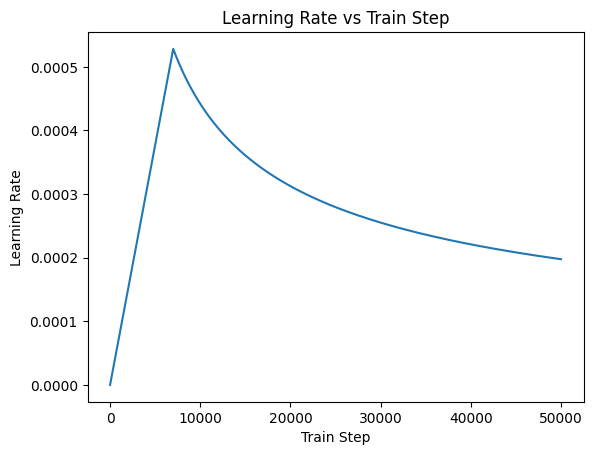

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dim_model=D, warmup_steps=7000):
    super().__init__()

    self.dim_model = dim_model
    self.dim_model = tf.cast(self.dim_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return (tf.math.rsqrt(self.dim_model) * tf.math.minimum(arg1, arg2))

# create optimizer
learning_rate = CustomSchedule(dim_model=D)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# plot learning rate
plt.plot(learning_rate(tf.range(50000, dtype=tf.float32)))
plt.title('Learning Rate vs Train Step')
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# make batches
train_len = int(int(data_len*0.8)/batch_size)*batch_size
val_len = int(int(data_len*0.1)/batch_size)*batch_size
test_len = data_len - train_len - val_len
train_inputs = inputs[:train_len]
train_outputs = outputs[:train_len]
val_inputs = inputs[train_len:train_len+val_len]
val_outputs = outputs[train_len:train_len+val_len]
print('Training inputs: ' + str(train_inputs))
print()
print('Training outputs: ' + str(train_outputs))
print()
test_inputs = inputs[train_len+val_len:]
test_outputs = outputs[train_len+val_len:]

# define loss and accuracy functions
def loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  s1_truths = []
  s1_preds = []
  s2_truths = []
  s2_preds = []
  for i in range(batch_size):
    s1_truths.append(truths[i][0])
    s1_preds.append(preds[i][0][tf.argmax(preds[i][0])])
    s2_truths.append(truths[i][1])
    s2_preds.append(preds[i][1][tf.argmax(preds[i][1])])
  s1_preds = tf.stack(s1_preds)
  s1_truths = tf.stack(s1_truths)
  s1_loss = tf.reduce_sum(loss_object(tf.expand_dims(s1_truths,axis=0), s1_preds))
  s2_preds = tf.stack(s2_preds)
  s2_truths = tf.stack(s2_truths)
  s2_loss = tf.reduce_sum(loss_object(tf.expand_dims(s2_truths,axis=0), s2_preds))
  return tf.add(s1_loss,s2_loss)

### evaluation

In [ ]:
def evaluate(model, inputs, outputs):
  test_preds = model(inputs)

  # plot place guess
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(test_preds[:,0,:])
  plt.xlabel('place')
  plt.ylabel('player')
  plt.title('model guess')
  plt.subplot(1, 2, 2)

  # plot place truth
  to_plot = np.zeros([len(test_preds), len(test_preds[0][0])], int)
  for i in range(len(to_plot)):
    to_plot[i,outputs[i][0]] = 1
  plt.subplot(1, 2, 2)
  plt.imshow(to_plot)
  plt.xlabel('place')
  plt.title('truth')
  plt.show()

  # plot score guess
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(test_preds[:,1,:])
  plt.xlabel('score')
  plt.ylabel('player')
  plt.xticks(range(0,60,10),range(-30,30,10))
  plt.title('model guess')

  # plot score truth
  to_plot = np.zeros([len(test_preds), len(test_preds[0][1])], int)
  for i in range(len(test_preds)):
    to_plot[i,outputs[i][1]] = 1
  plt.subplot(1, 2, 2)
  plt.imshow(to_plot)
  plt.xlabel('score')
  plt.xticks(range(0,60,10),range(-30,30,10))
  plt.title('truth')
  plt.show()

In [ ]:
model = PGA()

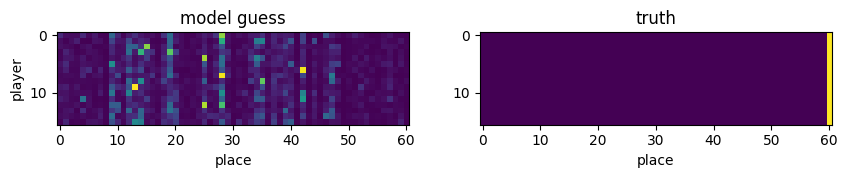

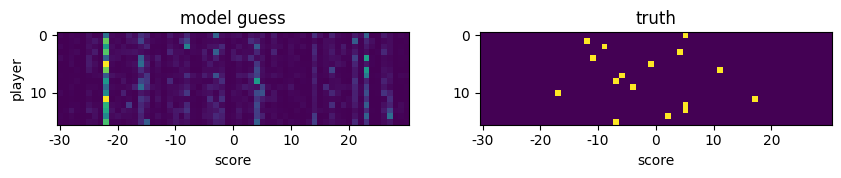

In [ ]:
evaluate(model,test_inputs[:32],test_outputs[:32])

In [ ]:
model.summary()

Model: "pga_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pga_positional_embedding_5  multiple                  256000    
  (PGAPositionalEmbedding)                                       
                                                                 
 pga_encoder_30 (PGAEncoder  multiple                  10503168  
 )                                                               
                                                                 
 pga_encoder_31 (PGAEncoder  multiple                  10503168  
 )                                                               
                                                                 
 pga_encoder_32 (PGAEncoder  multiple                  10503168  
 )                                                               
                                                                 
 pga_encoder_33 (PGAEncoder  multiple                  105031

## training

In [ ]:
# compile model
model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])

# train model
model.fit(train_inputs, train_outputs, batch_size = batch_size, epochs = epochs, validation_data = (val_inputs, val_outputs))

Epoch 1/2


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-125-de7a427b71d9>", line 56, in loss  *
        s1_loss = tf.reduce_sum(loss_object(tf.expand_dims(s1_truths,axis=0), s1_preds))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(16,) and logits.shape=(1, 16)


In [ ]:
model.save_weights('model')

# testing

In [ ]:
model = PGA()

In [ ]:
model.load_weights('model')

In [ ]:
rand_indeces = [random.randint(0,data_len) for i in range(32)]
random_inputs = tf.gather(inputs,rand_indeces,axis=0)
random_outputs = tf.gather(outputs,rand_indeces,axis=0)

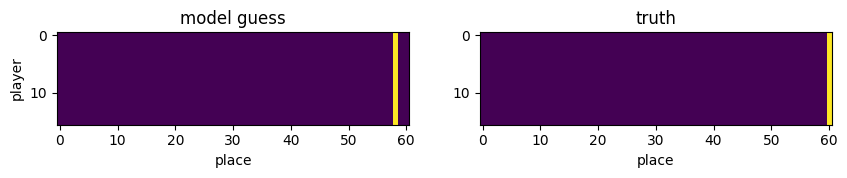

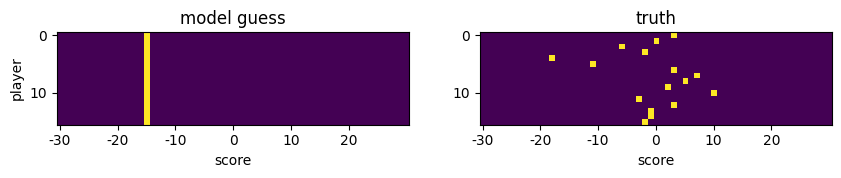

In [ ]:
evaluate(model,random_inputs,random_outputs)

In [ ]:
soft = model(random_inputs[:32])
pos_guess = int(tf.argmax(soft[0][0]))
score_guess = int(tf.argmax(soft[0][1]))
pos_truth = int(random_outputs[0][0])
score_truth = int(random_outputs[0][1])
print('Guess: ',pos_guess,score_guess)
print('Truth: ',pos_truth,score_truth)

Guess:  28 8
Truth:  60 33
